In [27]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import math

from pandas import read_csv
from scipy.optimize import curve_fit
import pickle

In [28]:
import sys
import sys
sys.path.append('../')
from inference.read_in_data import *
from inference.correlation_heatmap import *
from inference.calculating_tau import *

# Viscosity data

## Rheology

In [5]:
#expected D
kb=1.380649*10**(-23) # J*K^(-1)
T=300 # K
eta=0.61 # Pa*S
r=60*10**(-9) # m
D=kb*T/(6*math.pi*eta*r) #m^2/s
print(D) #m^2/s

6.003746257510443e-15


## DLS

In [6]:
#expected D
kb=1.380649*10**(-23) # J*K^(-1)
T=300 # K
eta=0.56 # Pa*S
r=60*10**(-9) # m
D=kb*T/(6*math.pi*eta*r) #m^2/s
print(D) #m^2/s

6.539795030502446e-15


# 0.02% 100um height 10x objective, 405 nm laser

In [7]:
video_time_length=60 #s
imgname='0p2nofluro_100nmbeads_100umheight_0p52au_10xobj_405nm_1min'
foldername='/Volumes/WENYUN WANG/20230209/tif_files/'

In [8]:
# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]
framespeed=video_time_length/frame_number

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


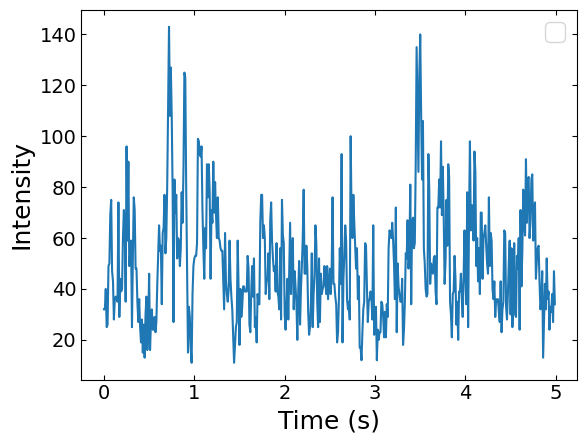

In [19]:
inten=[]
for t in range(0,img.shape[0],1):
  inten.append(img[t][10,300])
plt.plot([i*framespeed for i in range(0,500)],inten[0:500])
plt.tick_params(bottom=True, top=True, left=True, right=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (s)',size=18)
plt.ylabel('Intensity',size=18)
plt.legend(fontsize=18)


## Temporal autocorrelation

In [21]:
def compute_g2t_wo_kernel(px,laglist_g2t,normalize=True,plot=False):
    intensity=[]
    for t in range(0,img.shape[0],1):
        intensity.append(img[t][px[0],px[1]])
        
    g2t=np.zeros(len(laglist_g2t))
    for lag in laglist_g2t:
        numerator=[]
        denumerator1=[]
        denumerator2=[]
        max_t_range=5000 #len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator.append(int(intensity[t])*int(intensity[t+lag]))
            denumerator1.append(intensity[t])
            denumerator2.append(intensity[t+lag])
        g2t[lag]=(np.array(numerator).mean()/np.array(denumerator1).mean()/np.array(denumerator2).mean())-1
        #g2t[lag]=g2t[lag]/g2t[0]
    if normalize:
        first=g2t[0]
        for lag in laglist_g2t:
            g2t[lag]=g2t[lag]/first
    if plot == True:
        plt.figure(figsize=(8,5))
        plt.plot(intensity[0:200],'k-')
        plt.xlabel("Time",fontsize=18)
        plt.ylabel("Intensity",fontsize=18)
        plt.tick_params(direction='in')
    return g2t

### One pixel

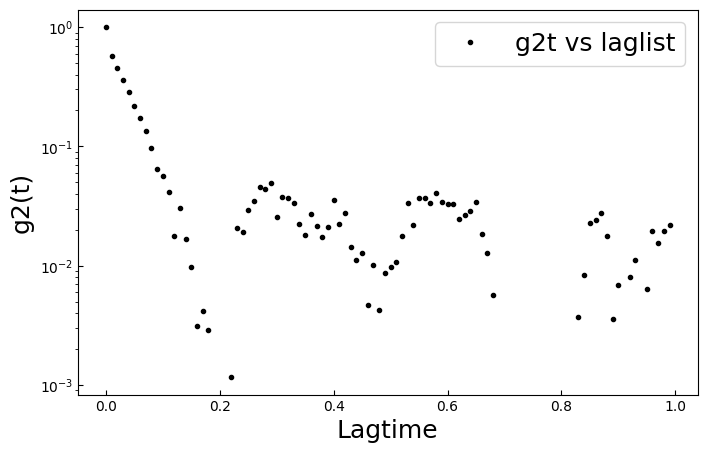

In [23]:
laglist_g2t=range(0,100,1)
px=[10,300]
g2t=compute_g2t_wo_kernel(px,laglist_g2t)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t,g2t,'k.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.yscale('log')
plt.tick_params(direction='in')

tau is: 0.03790790162088929
y = -26.37972 * x + -0.23403


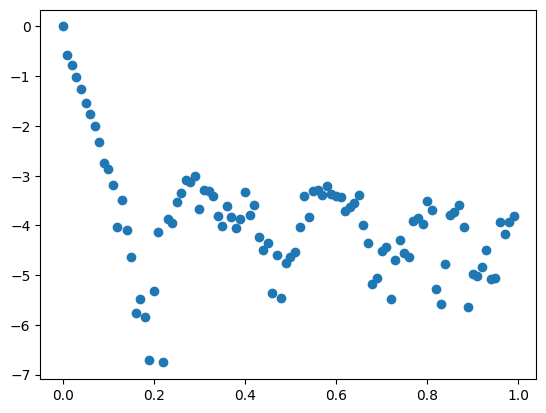

R square is 0.991552842055356


In [24]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(g2t),lagtime_g2t,1,10, True)

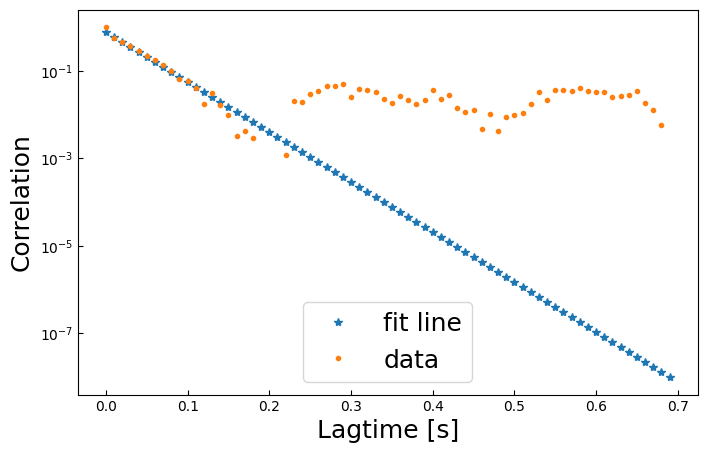

In [27]:
reconstruct(lagtime_g2t[0:70],plateau,np.array(g2t[0:70]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")


### Histogram

In [7]:
def calculate_D_10x(a):
    n=1.47
    angle=np.arange(180-19.77,180+19.77,1)
    lamda=405 #nm
    k=2*math.pi/lamda
    q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

    q=np.mean(q)
    D=a/(-2*q**2)
    return D

In [8]:
laglist_g2t=range(0,100,1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
tau_store=np.zeros((64,512))
D_store=np.zeros((64,512))
for y in range(64):
    for x in range(512):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        tau, a, b=fit_exponential_decay_rsq(0,np.array(g2t),lagtime_g2t,1,10,False)
        D_store[y,x]=calculate_D(a)
        tau_store[y,x]=tau

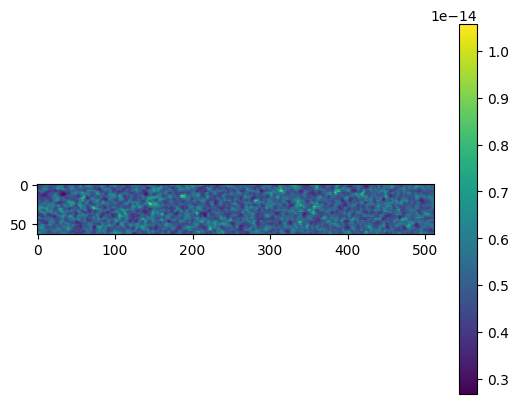

In [11]:
plt.imshow(D_store)
plt.colorbar()

(array([1.9200e+02, 3.9840e+03, 1.2669e+04, 1.0479e+04, 4.0870e+03,
        1.0480e+03, 2.2500e+02, 5.7000e+01, 1.9000e+01, 8.0000e+00]),
 array([2.67629120e-15, 3.46516523e-15, 4.25403926e-15, 5.04291330e-15,
        5.83178733e-15, 6.62066136e-15, 7.40953539e-15, 8.19840943e-15,
        8.98728346e-15, 9.77615749e-15, 1.05650315e-14]),
 <BarContainer object of 10 artists>)

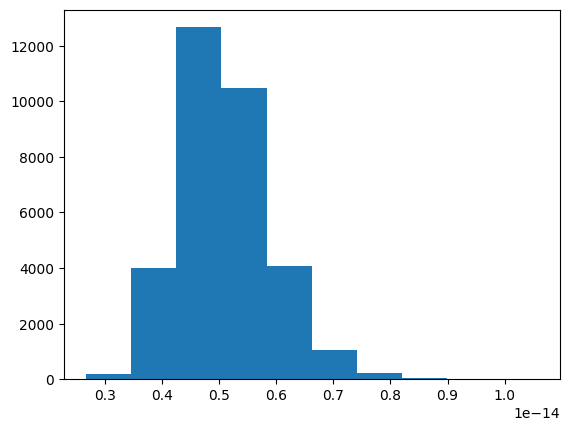

In [15]:
plt.hist(D_store.ravel())

In [6]:
D_store

NameError: name 'D_store' is not defined

In [15]:
mean_D=np.mean(D_store)
print(mean_D)
print(np.std(D_store))

5.098566176180078e-15
7.992637764321324e-16


In [16]:
pickle.dump(D_store, open('/Users/wenyun/Desktop/+imgname'+'_g2tcorrrelation_map_temporal.p',"wb"))

In [12]:
D_store=pickle.load(open(foldername+imgname+'_g2tcorrrelation_map_temporal.p', "rb"))

### average over sizes

In [ ]:
laglist_g2t=range(0,100,1)
averaged_g2t=[]
for y in range(0,20,1):
    for x in range(200,300,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [ ]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg_temporal.p',"wb"))

In [ ]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg_temporal.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1) # assumes that the laglist is calculated is consective
lagtime_g2t= [element * framespeed for element in laglist_g2t]

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:100],average_g2t[0:100],'k.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

# 0.02% 100um height 25x oil objective, 405 nm laser

In [29]:
video_time_length=60 #s
imgname='0p2nofluro_100nmbeads_100umheight_0p52au_25xoilobj_405nm_1min'
foldername='/Volumes/WENYUN WANG/20230209/tif_files/'

In [30]:
# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]
framespeed=video_time_length/frame_number

In [31]:
def calculate_D_25xoil(a):
    n=1.47
    angle=np.arange(180-32.9,180+32.9,1)
    lamda=405 #nm
    k=2*math.pi/lamda
    q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

    q=np.mean(q)
    D=a/(-2*q**2)
    return D

## Temporal Autocorrelation

### One pixel

(0.0, 0.9896701099633456)

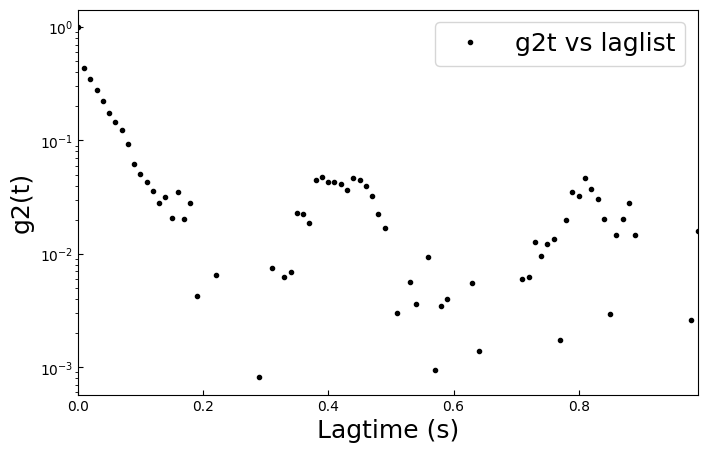

In [32]:
laglist_g2t=range(0,100,1)
px=[10,310]
g2t=compute_g2t_wo_kernel(px,laglist_g2t)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t,g2t,'k.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime (s)",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.yscale('log')
plt.tick_params(direction='in')
plt.xlim(0,lagtime_g2t[-1])

### histogram

In [26]:
laglist_g2t=range(0,100,1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
tau_store_25x=np.zeros((64,512))
D_store_25x=np.zeros((64,512))
for y in range(64):
    for x in range(512):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        tau, a, b=fit_exponential_decay_rsq(0,np.array(g2t),lagtime_g2t,1,10,False)
        D_store_25x[y,x]=calculate_D_25xoil(a)
        tau_store_25x[y,x]=tau

KeyboardInterrupt: 

In [ ]:
pickle.dump(D_store_25x, open('/Users/wenyun/Desktop/+imgname'+'_g2tcorrrelation_map_temporal_25xoil.p',"wb"))

(array([1.9160e+03, 1.7432e+04, 1.1144e+04, 1.9400e+03, 2.7500e+02,
        3.3000e+01, 1.6000e+01, 8.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([2.67829956e-15, 4.07673857e-15, 5.47517757e-15, 6.87361658e-15,
        8.27205559e-15, 9.67049459e-15, 1.10689336e-14, 1.24673726e-14,
        1.38658116e-14, 1.52642506e-14, 1.66626896e-14]),
 <BarContainer object of 10 artists>)

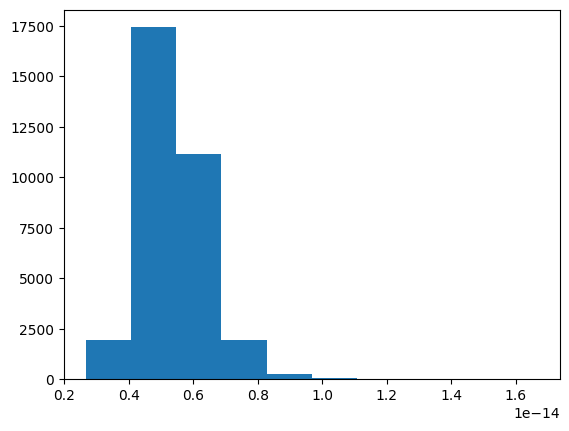

In [22]:
plt.hist(D_store_25x.ravel())

In [16]:
D_store_25x=pickle.load(open(foldername+imgname+'_g2tcorrrelation_map_temporal_25xoil.p', "rb"))
print(np.mean(D_store_25x))
print(np.std(D_store_25x))

5.384245181547029e-15
9.81083803866923e-16


In [11]:
laglist_g2t=range(0,100,1)
px=[10,300]
g2t=compute_g2t_wo_kernel(px,laglist_g2t,plot=True)
pickle.dump(g2t, open(foldername+imgname+'_g2tcorrrelation_temporal.p',"wb"))

NameError: name 'compute_g2t_wo_kernel' is not defined

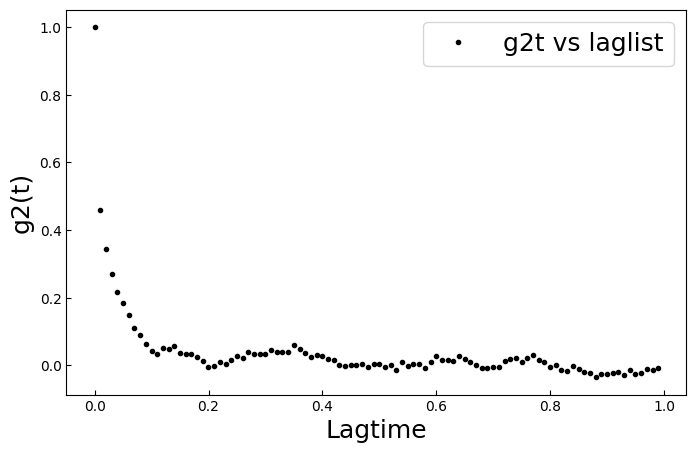

In [44]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t,g2t,'k.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

tau is: 0.04252962708709678
y = -23.51302 * x + -0.56394


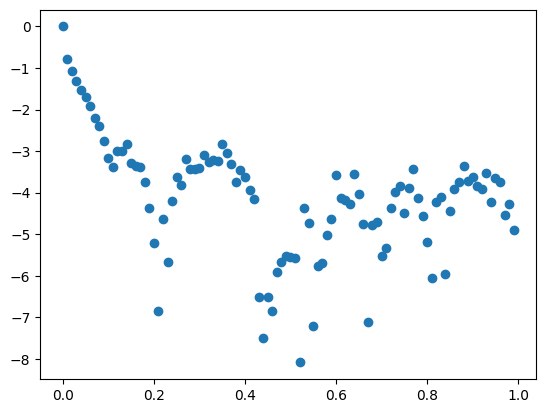

R square is 0.99431472707706


In [45]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(g2t),lagtime_g2t,1,10, True)

In [46]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

5.7088418046002e-15


## average over pixels

In [47]:
laglist_g2t=range(0,100,1)
averaged_g2t=[]
for y in range(0,20,1):
    for x in range(200,300,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [ ]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg_temporal.p',"wb"))

In [ ]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg_temporal.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1) # assumes that the laglist is calculated is consective
lagtime_g2t= [element * framespeed for element in laglist_g2t]

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:100],average_g2t[0:100],'k.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')